In [ ]:
#earlier code prepared it for algorithm

In [ ]:
#Code below generated csv clustered data

import scipy.io
import pandas as pd
import numpy as np
import os

input_folder = 'data/Tail_681_1'
output_folder = 'output'
os.makedirs(output_folder, exist_ok=True)

for file in os.listdir(input_folder):
    if file.endswith('.mat'):
        file_path = os.path.join(input_folder, file)
        mat = scipy.io.loadmat(file_path)
        unpacked = {}

        for k, v in mat.items():
            if not k.startswith('__') and isinstance(v, np.ndarray):
                try:
                    val = v.item()
                    if isinstance(val, (int, float, np.number)):
                        unpacked[k] = np.array([val])
                    elif isinstance(val, np.ndarray):
                        unpacked[k] = val.flatten()
                    elif isinstance(val, tuple):
                        first = val[0]
                        if isinstance(first, np.ndarray):
                            unpacked[k] = first.flatten()
                        elif isinstance(first, (int, float, np.number)):
                            unpacked[k] = np.array([first])
                        else:
                            print(f"⚠ Skipping {k}: tuple contains {type(first)}")
                    else:
                        print(f"⚠ Skipping {k}: unexpected type {type(val)}")
                except Exception as e:
                    print(f"⚠ Could not process {k}: {e}")

        if unpacked:
            max_len = max(len(a) for a in unpacked.values())
            for key in unpacked:
                arr = unpacked[key].astype(float)
                if len(arr) < max_len:
                    arr = np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan)
                unpacked[key] = arr

            df_file = pd.DataFrame(unpacked)
            df_file['filename'] = file

            # Save individual CSV immediately
            output_file = os.path.join(output_folder, file.replace('.mat', '.csv'))
            df_file.to_csv(output_file, index=False)
            print(f"✅ Saved {output_file}")


import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans

input_folder = 'output'
processed_folder = 'processed_output'
os.makedirs(processed_folder, exist_ok=True)

# Define columns of interest
important_cols = ['ALT', 'IAS', 'TH']

# Loop through CSV files
for file in os.listdir(input_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(input_folder, file)
        df = pd.read_csv(file_path)

        # Check available columns
        cols_present = [col for col in important_cols if col in df.columns]

        if not cols_present:
            print(f"⚠ Skipping {file}: no required columns found")
            continue

        # Feature engineering
        for col in cols_present:
            df[f'{col}_diff'] = df[col].diff()
            df[f'{col}_accel'] = df[f'{col}_diff'].diff()
        df.fillna(0, inplace=True)

        # Simple phase labeling
        if 'ALT' in df.columns:
            df['phase'] = 'unknown'
            df.loc[df['ALT'] < 1000, 'phase'] = 'taxi'
            df.loc[(df['ALT'] >= 1000) & (df['ALT'] < 10000), 'phase'] = 'climb'
            df.loc[df['ALT'] >= 10000, 'phase'] = 'cruise'
        else:
            df['phase'] = 'unknown'

        # Clustering (use only available engineered features)
        feature_cols = [f'{col}_diff' for col in cols_present]
        X = df[feature_cols].fillna(0)

        if len(X) >= 4:  # Avoid running KMeans on tiny files
            kmeans = KMeans(n_clusters=4, random_state=42)
            df['cluster'] = kmeans.fit_predict(X)
        else:
            df['cluster'] = -1  # Mark as invalid

        # Save processed file
        output_path = os.path.join(processed_folder, file.replace('.csv', '_processed.csv'))
        df.to_csv(output_path, index=False)
        print(f"✅ Processed and saved: {output_path}")


In [ ]:
# idnt think code below worked...

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# ====================
# 1️⃣ LOAD DATA IN CHUNKS
# ====================
chunk_size = 1_000_000  # adjust this depending on your RAM
chunks = []
for chunk in pd.read_csv('output/combined_all.csv', chunksize=chunk_size):
    chunks.append(chunk)
    print(f"✅ Loaded chunk with shape {chunk.shape}")

df = pd.concat(chunks, ignore_index=True)
print(f"✅ Final combined shape: {df.shape}")

# ====================
# 2️⃣ SAMPLE FOR EXPLORATION + ML
# ====================
sample_frac = 0.1  # take 10% random sample for analysis
df_sampled = df.sample(frac=sample_frac, random_state=42)
print(f"✅ Sampled down to shape: {df_sampled.shape}")

# ====================
# 3️⃣ CLEAN + PREPARE
# ====================
df_sampled = df_sampled.dropna(axis=1, thresh=len(df_sampled)*0.5)
df_sampled = df_sampled.fillna(0)
if 'filename' in df_sampled.columns:
    df_sampled = df_sampled.drop(columns=['filename'])

# ====================
# 4️⃣ VISUALIZE ALTITUDE + CLUSTER
# ====================
plt.figure(figsize=(12,4))
plt.scatter(df_sampled.index, df_sampled['ALT'], c=df_sampled['cluster'], cmap='viridis', s=1)
plt.title('Altitude over Index by Cluster (Sampled)')
plt.xlabel('Index')
plt.ylabel('Altitude')
plt.show()

plt.figure(figsize=(12,4))
for phase in df_sampled['phase'].unique():
    subset = df_sampled[df_sampled['phase'] == phase]
    plt.scatter(subset.index, subset['ALT'], label=phase, s=1)
plt.title('Altitude over Index by Phase (Sampled)')
plt.xlabel('Index')
plt.ylabel('Altitude')
plt.legend()
plt.show()

# ====================
# 5️⃣ PHASE VS. CLUSTER AGREEMENT
# ====================
cross_tab = pd.crosstab(df_sampled['phase'], df_sampled['cluster'])
print("\n📊 Phase vs. Cluster Crosstab:\n", cross_tab)

sns.heatmap(cross_tab, annot=True, fmt='d', cmap='coolwarm')
plt.title('Phase vs. Cluster Heatmap (Sampled)')
plt.show()

# ====================
# 6️⃣ CORRELATION HEATMAP
# ====================
features = [col for col in df_sampled.columns if df_sampled[col].dtype != 'object' and col not in ['phase', 'cluster']]
corr = df_sampled[features].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap (Sampled)')
plt.show()

# ====================
# 7️⃣ SUPERVISED ML: PREDICT PHASE
# ====================
X = df_sampled[features]
y = df_sampled['phase']

y_encoded = pd.factorize(y)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n✅ RandomForest Classifier Report (Sampled Data):")
print(classification_report(y_test, y_pred))

# ====================
# 8️⃣ CONFUSION MATRIX
# ====================
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Sampled Data)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


✅ Loaded chunk with shape (1000000, 193)
✅ Loaded chunk with shape (1000000, 193)
✅ Loaded chunk with shape (1000000, 193)
✅ Loaded chunk with shape (1000000, 193)
✅ Loaded chunk with shape (1000000, 193)
✅ Loaded chunk with shape (1000000, 193)
✅ Loaded chunk with shape (1000000, 193)
✅ Loaded chunk with shape (1000000, 193)
✅ Loaded chunk with shape (1000000, 193)
✅ Loaded chunk with shape (1000000, 193)
✅ Loaded chunk with shape (1000000, 193)
✅ Loaded chunk with shape (949455, 193)


In [8]:
#start here

In [ ]:
#SO what you will do is run this code, once you convert all your mat to one csv.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

chunk_size = 1_000_000
input_file = 'output/combined_all.csv'

sampled_chunks = []

for chunk in pd.read_csv(input_file, chunksize=chunk_size):
    print(f"✅ Processing chunk with shape {chunk.shape}")
    # Sample 10% of each chunk
    sampled = chunk.sample(frac=0.1, random_state=42)
    sampled_chunks.append(sampled)

# Combine only the small samples
df = pd.concat(sampled_chunks, ignore_index=True)
print(f"✅ Combined sampled shape: {df.shape}")


✅ Processing chunk with shape (1000000, 193)
✅ Processing chunk with shape (1000000, 193)
✅ Processing chunk with shape (1000000, 193)
✅ Processing chunk with shape (1000000, 193)
✅ Processing chunk with shape (1000000, 193)
✅ Processing chunk with shape (1000000, 193)
✅ Processing chunk with shape (1000000, 193)
✅ Processing chunk with shape (1000000, 193)
✅ Processing chunk with shape (1000000, 193)
✅ Processing chunk with shape (1000000, 193)
✅ Processing chunk with shape (1000000, 193)
✅ Processing chunk with shape (949455, 193)
✅ Combined sampled shape: (1194946, 193)


In [2]:
# Drop columns with >50% NaNs
df = df.dropna(axis=1, thresh=len(df)*0.5)

# Fill remaining NaNs
df = df.fillna(0)

# Drop non-numeric columns like filename (if present)
if 'filename' in df.columns:
    df = df.drop(columns=['filename'])

print(f"✅ Cleaned sampled data shape: {df.shape}")


✅ Cleaned sampled data shape: (1194946, 192)


In [3]:
print("✅ Phase counts:")
print(df['phase'].value_counts())

print("\n✅ Cluster counts:")
print(df['cluster'].value_counts())


✅ Phase counts:
taxi      970028
cruise    158457
climb      66461
Name: phase, dtype: int64

✅ Cluster counts:
0    962986
1    166811
3     43706
2     21443
Name: cluster, dtype: int64


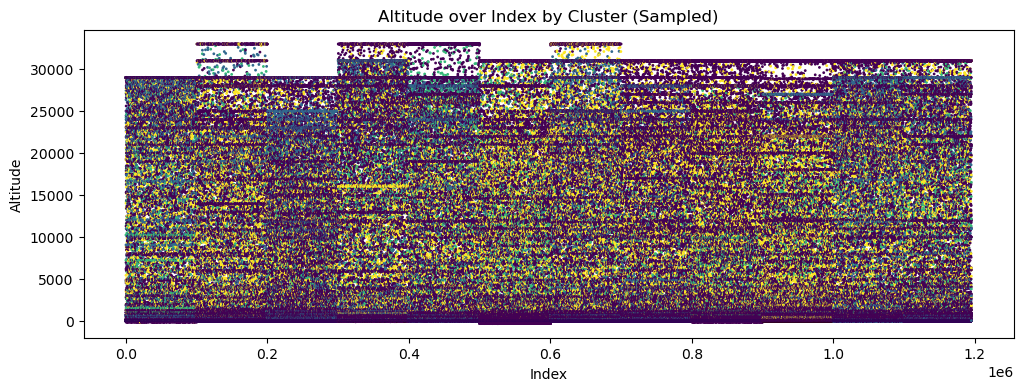

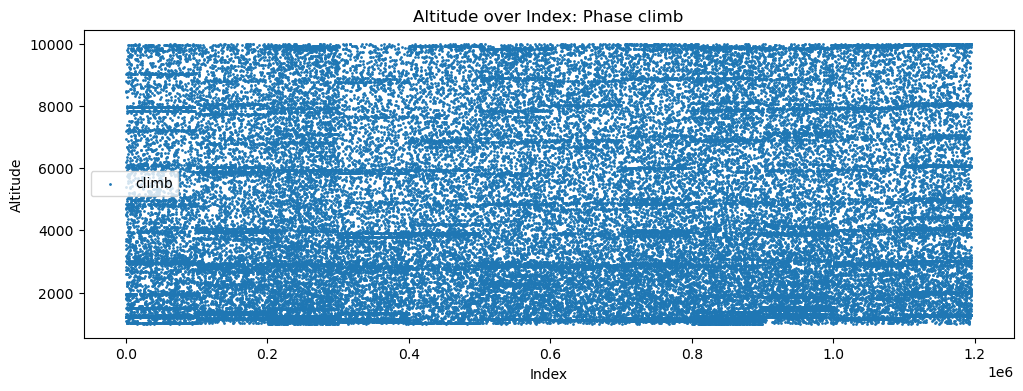

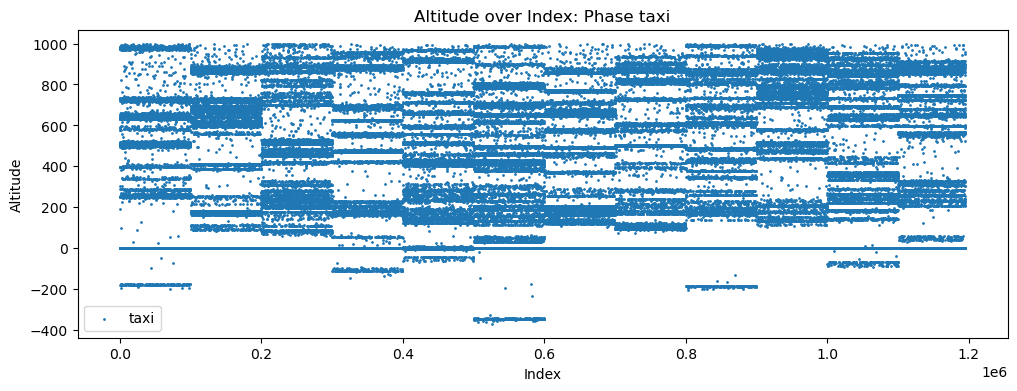

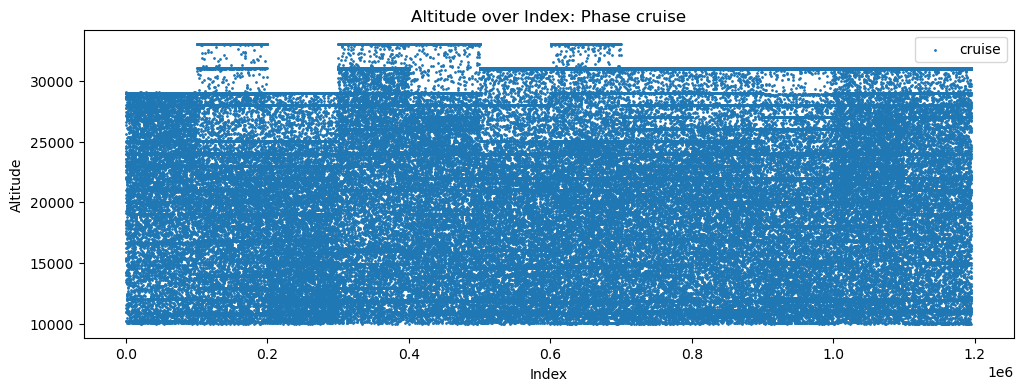

In [4]:
# Altitude by cluster
plt.figure(figsize=(12,4))
plt.scatter(df.index, df['ALT'], c=df['cluster'], cmap='viridis', s=1)
plt.title('Altitude over Index by Cluster (Sampled)')
plt.xlabel('Index')
plt.ylabel('Altitude')
plt.show()

# Altitude by phase
for phase in df['phase'].unique():
    subset = df[df['phase'] == phase]
    plt.figure(figsize=(12,4))
    plt.scatter(subset.index, subset['ALT'], label=phase, s=1)
    plt.title(f'Altitude over Index: Phase {phase}')
    plt.xlabel('Index')
    plt.ylabel('Altitude')
    plt.legend()
    plt.show()



📊 Phase vs. Cluster Crosstab:
 cluster       0       1     2      3
phase                               
climb     42251    6312  6388  11510
cruise   106551   22099  8783  21024
taxi     814184  138400  6272  11172


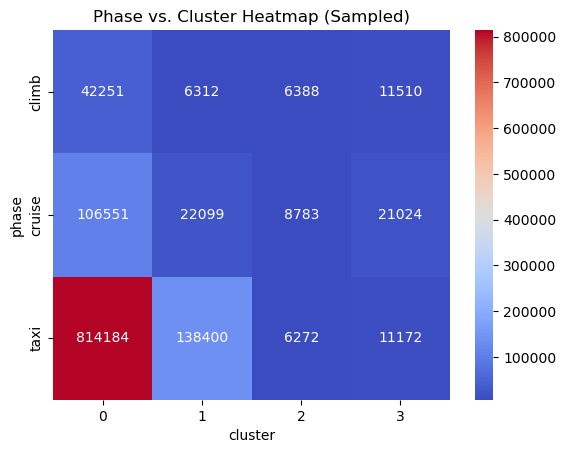

In [5]:
cross_tab = pd.crosstab(df['phase'], df['cluster'])
print("\n📊 Phase vs. Cluster Crosstab:\n", cross_tab)

sns.heatmap(cross_tab, annot=True, fmt='d', cmap='coolwarm')
plt.title('Phase vs. Cluster Heatmap (Sampled)')
plt.show()


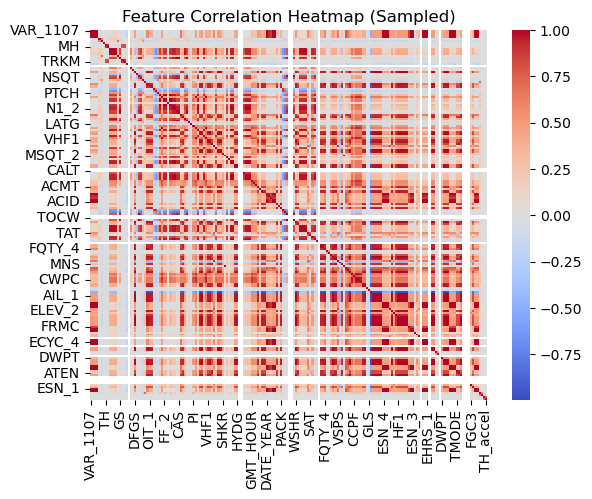

In [6]:
features = [col for col in df.columns if df[col].dtype != 'object' and col not in ['phase', 'cluster']]
corr = df[features].corr()

sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap (Sampled)')
plt.show()



✅ RandomForest Classifier Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13268
           1       1.00      1.00      1.00    193980
           2       1.00      1.00      1.00     31742

    accuracy                           1.00    238990
   macro avg       1.00      1.00      1.00    238990
weighted avg       1.00      1.00      1.00    238990



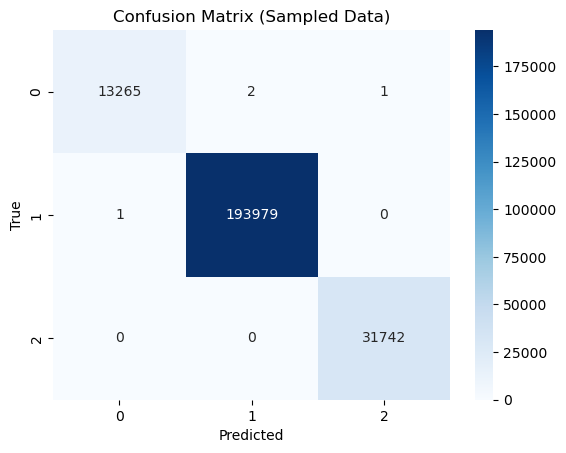

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = df[features]
y = df['phase']

# Encode phase labels
y_encoded = pd.factorize(y)[0]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluate
print("\n✅ RandomForest Classifier Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Sampled Data)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
#add dataset for testing accuracy